# Install Spark

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (123 kB/s)
Reading package lists... Done


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

In [3]:
!ls

reported-crimes.csv	   spark-2.3.1-bin-hadoop2.7.tgz
sample_data		   spark-2.3.1-bin-hadoop2.7.tgz.1
spark-2.3.1-bin-hadoop2.7  spark-warehouse


In [4]:
import findspark
findspark.init()
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

# Downloading and preprocessing Chicago's reported crime

In [6]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
!ls -l

--2020-04-21 11:42:27--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [            <=>     ]   1.56G  3.24MB/s    in 8m 7s   

2020-04-21 11:50:35 (3.28 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1675501425]

total 3713672
-rw-r--r--  1 root root 1675501425 Apr 20 11:10  reported-crimes.csv
-rw-r--r--  1 root root 1675501425 Apr 20 11:10 'rows.csv?accessType=DOWNLOAD'
drwxr-xr-x  1 root root       4096 Apr  3 16:24  sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018  spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018  spark-2.3.1-bin-hadoop2.7.tgz
-rw-r--r--  1 root root  2258

In [7]:
!ls

 reported-crimes.csv		 spark-2.3.1-bin-hadoop2.7.tgz
'rows.csv?accessType=DOWNLOAD'	 spark-2.3.1-bin-hadoop2.7.tgz.1
 sample_data			 spark-warehouse
 spark-2.3.1-bin-hadoop2.7


In [8]:
!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
!ls -l

total 2077436
-rw-r--r--  1 root root 1675501425 Apr 20 11:10 reported-crimes.csv
drwxr-xr-x  1 root root       4096 Apr  3 16:24 sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018 spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.tgz
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.tgz.1
drwxr-xr-x  2 root root       4096 Apr 21 10:53 spark-warehouse


In [16]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == lit('2001-01-01'))
rc.show(5, truncate=False) # To show long fields without truncating

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11231026|   JB152500|2001-01-01 00:00:00| 050XX N ASHLAND AVE|1754|OFFENSE INVOLVING...|AGG SEX ASSLT OF ...|           RESIDENCE| false|   false|2032|     020|  47|             3|      

In [17]:
rc.count()

191

# Reading data with custom schemas

In [18]:
# Checkig current schema
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [0]:
# Importing for defining custom schema
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, BooleanType, DoubleType, IntegerType

In [20]:
# Listing column names
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [0]:
# List contating field to type map
labels = [
 ('ID',StringType()),
 ('Case Number',StringType()),
 ('Date',TimestampType()),
 ('Block',StringType()),
 ('IUCR',StringType()),
 ('Primary Type',StringType()),
 ('Description',StringType()),
 ('Location Description',StringType()),
 ('Arrest',StringType()),
 ('Domestic',BooleanType()),
 ('Beat',StringType()),
 ('District',StringType()),
 ('Ward',StringType()),
 ('Community Area',StringType()),
 ('FBI Code',StringType()),
 ('X Coordinate',StringType()),
 ('Y Coordinate',StringType()),
 ('Year',IntegerType()),
 ('Updated On',StringType()),
 ('Latitude',DoubleType()),
 ('Longitude',DoubleType()),
 ('Location',StringType())
]

In [22]:
# Creating custom schema
schema = StructType([StructField(label[0], label[1], True) for label in labels]) # True specifies that our field is nullable
schema

StructType(List(StructField(ID,StringType,true),StructField(Case Number,StringType,true),StructField(Date,TimestampType,true),StructField(Block,StringType,true),StructField(IUCR,StringType,true),StructField(Primary Type,StringType,true),StructField(Description,StringType,true),StructField(Location Description,StringType,true),StructField(Arrest,StringType,true),StructField(Domestic,BooleanType,true),StructField(Beat,StringType,true),StructField(District,StringType,true),StructField(Ward,StringType,true),StructField(Community Area,StringType,true),StructField(FBI Code,StringType,true),StructField(X Coordinate,StringType,true),StructField(Y Coordinate,StringType,true),StructField(Year,IntegerType,true),StructField(Updated On,StringType,true),StructField(Latitude,DoubleType,true),StructField(Longitude,DoubleType,true),StructField(Location,StringType,true)))

In [23]:
rc = spark.read.csv("reported-crimes.csv", schema=schema)
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [24]:
rc.show(5)

+----+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+----+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|null|       null|null| null|null|        null|       null|                null|  null|    null|null|    null|null|          null|    null|        null|        null|null|      null|    null|     null|    null|
|null|       null|null| null|null|        null|       null|                null|  null|    null|null|    null|null|          null|    null|        null|        

Instead of seeing the first five rows, we are seeing nulls. This is because our schema doesn't conform with the data in our csv for e.g some of our strings cannot be converted to integer type, some have problem with date types and so on. Schema which was generated by default worked for us so we will continue using that.

In [25]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == lit('2001-01-01')) # Capture all data till 11 Nov 2018
rc.show(5)

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11231026|   JB152500|2001-01-01 00:00:00| 050XX N ASHLAND AVE|1754|OFFENSE INVOLVING...|AGG SEX ASSLT OF ...|           RESIDENCE| false|   false|2032|     020|  47|             3|      

# Working with columns

## Display first 5 rows of column IUCR

In [26]:
rc.select('IUCR').show(5)

+----+
|IUCR|
+----+
|1754|
|1562|
|1562|
|1562|
|0266|
+----+
only showing top 5 rows



In [27]:
rc.select(rc.IUCR).show(5)

+----+
|IUCR|
+----+
|1754|
|1562|
|1562|
|1562|
|0266|
+----+
only showing top 5 rows



In [28]:
rc.select(col('IUCR')).show(5)

+----+
|IUCR|
+----+
|1754|
|1562|
|1562|
|1562|
|0266|
+----+
only showing top 5 rows



## Display first 4 rows of columns Case Number, Date and Arrest

In [29]:
rc.select('Case Number', 'Date', 'Arrest').show(4)

+-----------+-------------------+------+
|Case Number|               Date|Arrest|
+-----------+-------------------+------+
|   JB152500|2001-01-01 00:00:00| false|
|   HX403553|2001-01-01 00:00:00| false|
|   HX397222|2001-01-01 00:00:00| false|
|   HX403550|2001-01-01 00:00:00| false|
+-----------+-------------------+------+
only showing top 4 rows



## Add a column named One with all entries as 1

In [0]:
from pyspark.sql.functions import lit

In [31]:
rc.withColumn('One', lit(1)).show(5) # This won't add column to original rc as we haven't reassigned rc with the result

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+---+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|One|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+---+
|11231026|   JB152500|2001-01-01 00:00:00| 050XX N ASHLAND AVE|1754|OFFENSE INVOLVING...|AGG SEX ASSLT OF ...|           RESIDENCE| false|   false|2032|     020|  47|         

In [0]:
rc = rc.withColumn('One', lit(1)) # This will ad new column to rc called One

In [33]:
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location',
 'One']

## Multiply entire column One with 2

In [34]:
rc = rc.withColumn('One', 2*rc['One'])
rc.show(5)

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+---+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|One|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+---+
|11231026|   JB152500|2001-01-01 00:00:00| 050XX N ASHLAND AVE|1754|OFFENSE INVOLVING...|AGG SEX ASSLT OF ...|           RESIDENCE| false|   false|2032|     020|  47|         

## Rename column One to Two

In [35]:
rc = rc.withColumnRenamed('One', 'Two')
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location',
 'Two']

## Drop column Two

In [36]:
rc = rc.drop('Two')
rc.show(5)

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11231026|   JB152500|2001-01-01 00:00:00| 050XX N ASHLAND AVE|1754|OFFENSE INVOLVING...|AGG SEX ASSLT OF ...|           RESIDENCE| false|   false|2032|     020|  47|             3|      

# Working with rows

## Read data for 02 Jan 2001 from csv

In [37]:
one_day = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == lit('2001-01-02')) # Capture data for 12 Nov 2018
one_day.show(5)

+-------+-----------+-------------------+--------------------+----+---------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|     ID|Case Number|               Date|               Block|IUCR|   Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+-------+-----------+-------------------+--------------------+----+---------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|1311133|    G002251|2001-01-02 00:00:00|076XX S DR MARTN ...|0810|          THEFT|  OVER $500|              STREET| false|   false|0624|     006|null|          null|      

## Count number of crimes happened on 12 Nov 2018

In [38]:
one_day.count()

24

## Add crimes happened on 12 Nov 2018 to original dataframe

In [39]:
rc = rc.union(one_day)
rc.orderBy('Date', ascending=False).show(5)
# Since our new df columns will be added at the end
# So ordering by date descending to see added columns

+-------+-----------+-------------------+--------------------+----+---------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|     ID|Case Number|               Date|               Block|IUCR|   Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+-------+-----------+-------------------+--------------------+----+---------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|1312615|    G003834|2001-01-02 00:00:00|       020XX W 76 ST|0810|          THEFT|  OVER $500|    RESIDENCE-GARAGE| false|   false|0611|     006|null|          null|      

We can see that the top 3 rows are the newly added rows

## What are top 10 number of reported crimes by Primary type in descending order of occurence?

In [40]:
rc.groupby('Primary Type').count().show()

+--------------------+-----+
|        Primary Type|count|
+--------------------+-----+
|OFFENSE INVOLVING...|   29|
|CRIMINAL SEXUAL A...|    1|
|             ASSAULT|    3|
| MOTOR VEHICLE THEFT|    1|
|               THEFT|   78|
|             BATTERY|    2|
| CRIM SEXUAL ASSAULT|   12|
|  DECEPTIVE PRACTICE|   18|
|         SEX OFFENSE|   39|
|     CRIMINAL DAMAGE|   22|
|       OTHER OFFENSE|    9|
|            BURGLARY|    1|
+--------------------+-----+



The result is not ordered so adding logic to order.

In [41]:
rc.groupBy('Primary Type').count().orderBy('count', ascending=False).show(10)

+--------------------+-----+
|        Primary Type|count|
+--------------------+-----+
|               THEFT|   78|
|         SEX OFFENSE|   39|
|OFFENSE INVOLVING...|   29|
|     CRIMINAL DAMAGE|   22|
|  DECEPTIVE PRACTICE|   18|
| CRIM SEXUAL ASSAULT|   12|
|       OTHER OFFENSE|    9|
|             ASSAULT|    3|
|             BATTERY|    2|
|CRIMINAL SEXUAL A...|    1|
+--------------------+-----+
only showing top 10 rows



## What percentage of reported crimes resulted in an arrest?

In [44]:
rc.select('Arrest').distinct().show()

+------+
|Arrest|
+------+
| false|
|  true|
+------+



In [45]:
rc.filter(col('Arrest') == "true").count() / rc.select('Arrest').count() * 100

5.5813953488372094

## Top 3 locations for reported by crimes?

In [49]:
rc.groupby('Location Description').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|Location Description|count|
+--------------------+-----+
|           RESIDENCE|  104|
|CHURCH/SYNAGOGUE/...|   35|
|           APARTMENT|   20|
|              STREET|   18|
|               OTHER|   16|
|PARKING LOT/GARAG...|    5|
|                BANK|    3|
|COMMERCIAL / BUSI...|    3|
|    AIRPORT/AIRCRAFT|    2|
|FACTORY/MANUFACTU...|    2|
|    RESIDENCE-GARAGE|    2|
|    DEPARTMENT STORE|    2|
|            SIDEWALK|    1|
|  SMALL RETAIL STORE|    1|
|POLICE FACILITY/V...|    1|
+--------------------+-----+



# Functions

List of functions in pyspark:

In [46]:
from pyspark.sql import functions
print(dir(functions))

['AutoBatchedSerializer', 'Column', 'DataFrame', 'DataType', 'PandasUDFType', 'PickleSerializer', 'PythonEvalType', 'SparkContext', 'StringType', 'UserDefinedFunction', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_binary_mathfunctions', '_collect_list_doc', '_collect_set_doc', '_create_binary_mathfunction', '_create_function', '_create_udf', '_create_window_function', '_functions', '_functions_1_4', '_functions_1_6', '_functions_2_1', '_functions_deprecated', '_lit_doc', '_message', '_string_functions', '_test', '_to_java_column', '_to_seq', '_window_functions', '_wrap_deprecated_function', 'abs', 'acos', 'add_months', 'approxCountDistinct', 'approx_count_distinct', 'array', 'array_contains', 'asc', 'ascii', 'asin', 'atan', 'atan2', 'avg', 'base64', 'bin', 'bitwiseNOT', 'blacklist', 'broadcast', 'bround', 'cbrt', 'ceil', 'coalesce', 'col', 'collect_list', 'collect_set', 'column', 'concat', 'concat_ws', 'conv', 'c

## Display Primary Type as first 4 characters, lower case and upper case

In [0]:
from pyspark.sql.functions import lower, upper, substring

In [52]:
help(substring)

Help on function substring in module pyspark.sql.functions:

substring(str, pos, len)
    Substring starts at `pos` and is of length `len` when str is String type or
    returns the slice of byte array that starts at `pos` in byte and is of length `len`
    when str is Binary type.
    
    .. note:: The position is not zero based, but 1 based index.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(substring(df.s, 1, 2).alias('s')).collect()
    [Row(s='ab')]
    
    .. versionadded:: 1.5



In [57]:
rc.select( lower(col('Primary Type')), upper(col('Primary Type')), substring(col('Primary Type'), 1, 4)).show(5)

+--------------------+--------------------+-----------------------------+
| lower(Primary Type)| upper(Primary Type)|substring(Primary Type, 1, 4)|
+--------------------+--------------------+-----------------------------+
|offense involving...|OFFENSE INVOLVING...|                         OFFE|
|         sex offense|         SEX OFFENSE|                         SEX |
|         sex offense|         SEX OFFENSE|                         SEX |
|         sex offense|         SEX OFFENSE|                         SEX |
| crim sexual assault| CRIM SEXUAL ASSAULT|                         CRIM|
+--------------------+--------------------+-----------------------------+
only showing top 5 rows



## Show oldest and most recent date

In [0]:
from pyspark.sql.functions import min, max

In [60]:
rc.select(min(col('Date')), max(col('Date'))).show()

+-------------------+-------------------+
|          min(Date)|          max(Date)|
+-------------------+-------------------+
|2001-01-01 00:00:00|2001-01-02 00:00:00|
+-------------------+-------------------+



## 3 days earliear than oldest date and 3 days later than most recent date

In [0]:
from pyspark.sql.functions import date_add, date_sub

In [62]:
help(date_add)

Help on function date_add in module pyspark.sql.functions:

date_add(start, days)
    Returns the date that is `days` days after `start`
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_add(df.dt, 1).alias('next_date')).collect()
    [Row(next_date=datetime.date(2015, 4, 9))]
    
    .. versionadded:: 1.5



In [64]:
rc.select(date_sub(min(col('Date')),3), date_add(max(col('Date')),3)).show()

+----------------------+----------------------+
|date_sub(min(Date), 3)|date_add(max(Date), 3)|
+----------------------+----------------------+
|            2000-12-29|            2001-01-05|
+----------------------+----------------------+



## Convert to different date formats

In [0]:
from pyspark.sql.functions import to_date, to_timestamp, lit

### 2019-12-25 13:30:00

In [69]:
df = spark.createDataFrame([("2019-12-25 13:30:00",)], ['Christmas'])
df.show(1)

+-------------------+
|          Christmas|
+-------------------+
|2019-12-25 13:30:00|
+-------------------+



In [70]:
df.select(to_date(col('Christmas'), 'yyyy-MM-dd HH:mm:ss'), to_timestamp(col('Christmas'), 'yyyy-MM-dd HH:mm:ss')).show()

+-------------------------------------------+------------------------------------------------+
|to_date(`Christmas`, 'yyyy-MM-dd HH:mm:ss')|to_timestamp(`Christmas`, 'yyyy-MM-dd HH:mm:ss')|
+-------------------------------------------+------------------------------------------------+
|                                 2019-12-25|                             2019-12-25 13:30:00|
+-------------------------------------------+------------------------------------------------+



### 25/Dec/2019 13:30:00

In [72]:
df = spark.createDataFrame([("25/Dec/2019 13:30:00",)], ['Christmas'])
df.show(1)

+--------------------+
|           Christmas|
+--------------------+
|25/Dec/2019 13:30:00|
+--------------------+



In [73]:
df.select(to_date(col('Christmas'), 'dd/MMM/yyyy HH:mm:ss'), to_timestamp(col('Christmas'), 'dd/MMM/yyyy HH:mm:ss')).show()

+--------------------------------------------+-------------------------------------------------+
|to_date(`Christmas`, 'dd/MMM/yyyy HH:mm:ss')|to_timestamp(`Christmas`, 'dd/MMM/yyyy HH:mm:ss')|
+--------------------------------------------+-------------------------------------------------+
|                                  2019-12-25|                              2019-12-25 13:30:00|
+--------------------------------------------+-------------------------------------------------+



### 12/25/2019 01:30:00 PM

In [74]:
df = spark.createDataFrame([("12/25/2019 01:30:00 PM",)], ['Christmas'])
df.show(1)

+--------------------+
|           Christmas|
+--------------------+
|12/25/2019 01:30:...|
+--------------------+



In [76]:
df.select(to_date(col('Christmas'), 'MM/dd/yyyy hh:mm:ss aa'), to_timestamp(col('Christmas'), 'MM/dd/yyyy hh:mm:ss aa')).show()

+----------------------------------------------+---------------------------------------------------+
|to_date(`Christmas`, 'MM/dd/yyyy hh:mm:ss aa')|to_timestamp(`Christmas`, 'MM/dd/yyyy hh:mm:ss aa')|
+----------------------------------------------+---------------------------------------------------+
|                                    2019-12-25|                                2019-12-25 13:30:00|
+----------------------------------------------+---------------------------------------------------+



**Note: Consider writing functions in Java/Scala for performance when creating own functions**

## Joins

In [77]:
!wget -O police-station.csv https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
!ls -l

--2020-04-21 14:02:00--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘police-station.csv’

police-station.csv      [ <=>                ]   5.57K  --.-KB/s    in 0s      

2020-04-21 14:02:02 (584 MB/s) - ‘police-station.csv’ saved [5699]

total 2077444
-rw-r--r--  1 root root       5699 Aug 19  2019 police-station.csv
-rw-r--r--  1 root root 1675501425 Apr 20 11:10 reported-crimes.csv
drwxr-xr-x  1 root root       4096 Apr  3 16:24 sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018 spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.tgz
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.

In [89]:
ps = spark.read.csv('police-station.csv', header=True)
ps.show(5)

+------------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT| DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters|  Headquarters| 3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|           1|       Central|     1718 S State St|Chicago|   IL|60616|http://home.chica...|312-745-4290|312-745-3694|312-745-3693| 1176569.052| 1891771.704|41.85837259|-87.62735617|(41.858

In [80]:
rc.cache() # Caching the original dataframe
rc.count() # Running an action because cache command is lazily evaluated

215

In [81]:
ps.select(col('DISTRICT')).distinct().show(30)

+--------------------+
|            DISTRICT|
+--------------------+
|                   7|
|                  15|
|                  11|
|                   3|
|                   8|
|                  22|
|                  16|
|                   5|
|                  18|
|                  17|
|                   6|
|                  19|
|                  25|
|        Headquarters|
|                  24|
|                   9|
|                   1|
|                  20|
|                  10|
|                   4|
|                  12|
|                  14|
|                   2|
|",Chicago,IL,6060...|
+--------------------+



In [82]:
rc.select(col('District')).distinct().show(30)

+--------+
|District|
+--------+
|     009|
|     012|
|     024|
|     015|
|     006|
|     019|
|     020|
|     011|
|     025|
|     005|
|     003|
|     016|
|     018|
|     008|
|     022|
|     001|
|     014|
|     010|
|     004|
|     017|
|     007|
|     002|
+--------+



In [0]:
from pyspark.sql.functions import lpad

In [84]:
help(lpad)

Help on function lpad in module pyspark.sql.functions:

lpad(col, len, pad)
    Left-pad the string column to width `len` with `pad`.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(lpad(df.s, 6, '#').alias('s')).collect()
    [Row(s='##abcd')]
    
    .. versionadded:: 1.5



In [85]:
ps.select(lpad(col('DISTRICT'), 3, '0')).show(5)

+--------------------+
|lpad(DISTRICT, 3, 0)|
+--------------------+
|                 Hea|
|                 001|
|                 006|
|                 011|
|                 016|
+--------------------+
only showing top 5 rows



In [90]:
ps = ps.withColumn('Format_district', lpad(col('DISTRICT'), 3, '0'))
ps.show(5)

+------------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|    DISTRICT| DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+------------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|Headquarters|  Headquarters| 3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|            Hea|
|           1|       Central|     1718 S State St|Chicago|   IL|60616|http://home.chica...|312-745-4290|312-745-3694|312-745

In [92]:
ps.columns

['DISTRICT',
 'DISTRICT NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format_district']

In [94]:
rc.join(ps, rc.District == ps.Format_district, 'left_outer').drop(
    'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format_district'
).show()

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT| DISTRICT NAME|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+
|11231026|   JB152500|2001-01-01 00:00:00| 050XX N ASHLAND AVE|1754|OFFENSE INVOLVING...|AGG SEX ASSLT OF ...|           RESIDENCE| false|   false|2032|     020|  47|             3|      02|2001|10/27/2018 04:00:...|      20|       Lincoln|
| 9755209|   HX403553|2001-01-01 00:

Now we have district names in our rc dataframe.

# Practice

### Most frequently reported criminal sexual assault type

In [95]:
rc.select(col('Primary Type')).distinct().count()

12

In [97]:
rc.select(col('Primary Type')).distinct().show(12, truncate=False)

+--------------------------+
|Primary Type              |
+--------------------------+
|OFFENSE INVOLVING CHILDREN|
|CRIMINAL SEXUAL ASSAULT   |
|ASSAULT                   |
|MOTOR VEHICLE THEFT       |
|THEFT                     |
|BATTERY                   |
|CRIM SEXUAL ASSAULT       |
|DECEPTIVE PRACTICE        |
|SEX OFFENSE               |
|CRIMINAL DAMAGE           |
|OTHER OFFENSE             |
|BURGLARY                  |
+--------------------------+



In [98]:
csa = rc.filter( (col('Primary Type') == "CRIM SEXUAL ASSAULT") | (col('Primary Type') == "CRIMINAL SEXUAL ASSAULT") )
csa.show()

+--------+-----------+-------------------+--------------------+----+--------------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|      Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
| 9652075|   HX302422|2001-01-01 00:00:00|   033XX W WALNUT ST|0266| CRIM SEXUAL ASSAULT|        PREDATORY|           RESIDENCE| false| 

In [99]:
csa.groupby("Description").count().show()

+-----------------+-----+
|      Description|count|
+-----------------+-----+
|        PREDATORY|   10|
|AGGRAVATED: OTHER|    2|
|   NON-AGGRAVATED|    1|
+-----------------+-----+



### Day of week with most reported crimes

In [0]:
from pyspark.sql.functions import dayofweek

In [101]:
help(dayofweek)

Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col)
    Extract the day of the week of a given date as integer.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]
    
    .. versionadded:: 2.3



In [104]:
rc.select(col('Date'), dayofweek(col('Date'))).show(5)

+-------------------+---------------+
|               Date|dayofweek(Date)|
+-------------------+---------------+
|2001-01-01 00:00:00|              2|
|2001-01-01 00:00:00|              2|
|2001-01-01 00:00:00|              2|
|2001-01-01 00:00:00|              2|
|2001-01-01 00:00:00|              2|
+-------------------+---------------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import date_format

In [107]:
rc.select(col('Date'), date_format(col('Date'), "E")).show(5)

+-------------------+--------------------+
|               Date|date_format(Date, E)|
+-------------------+--------------------+
|2001-01-01 00:00:00|                 Mon|
|2001-01-01 00:00:00|                 Mon|
|2001-01-01 00:00:00|                 Mon|
|2001-01-01 00:00:00|                 Mon|
|2001-01-01 00:00:00|                 Mon|
+-------------------+--------------------+
only showing top 5 rows



In [108]:
rc.groupby(date_format(col('Date'), "E")).count().show()

+--------------------+-----+
|date_format(Date, E)|count|
+--------------------+-----+
|                 Mon|  191|
|                 Tue|   24|
+--------------------+-----+



In [112]:
dayCount = rc.groupby(date_format(col('Date'), "E")).count().collect()
dayCount

[Row(date_format(Date, E)='Mon', count=191),
 Row(date_format(Date, E)='Tue', count=24)]

In [113]:
dow = [x[0] for x in dayCount]
dow

['Mon', 'Tue']

In [114]:
cnt = [x[1] for x in dayCount]
cnt

[191, 24]

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [116]:
cp = pd.DataFrame({"Day of week": dow, "Count": cnt})
cp

,Day of week,Count
0,Mon,191
1,Tue,24


Text(0.5, 1.0, 'Crimes on days')

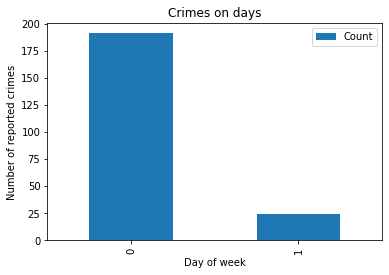

In [117]:
cp.sort_values("Count", ascending=False).plot.bar()
plt.xlabel("Day of week")
plt.ylabel("Number of reported crimes")
plt.title("Crimes on days")

# RDDs

Resilient Distributed Datasets or RDDs were a primary API for version one and they're still available in Spark version two. Now almost all the code we've been running using DataFrames compiles down to an RDD. An RDD is an immutable partitioned collection of records that can be worked on in parallel. With a DataFrame, each record is a structured row containing fields with a known schema. In the case of RDD, the records are just Java, Scala or Python objects. And so you have complete control over them. Although this has several advantages, there are a couple of challenges. Spark does not understand the inner structure of your records as it does with your DataFrames. This means that the optimizations you would have automatically got with DataFrames, you will need to manually recreate. 

The RDD APIs are available in Python as well as Scala and Java. You can get good performance with running RDDs with Scala and Java. However, running Python RDDs, is like running Python user-defined functions row by row. So we need to serialize the data to the Python process, work on it in Python and then serialize it back to the Java Virtual Machine. For this reason, it's recommended to stick with the high level APIs in Spark and only use the RDDs when absolutely necessary. 

Databricks ran a couple of experiments and compared the performance of Scala and Python grouped by aggregation on 10 million integer pairs on a single machine. In the case of DataFrames, both Scala and Python operations are compiled into JVM byte code. So there's little difference between them. Python and Scala DataFrames had two times better performance than Scala RDDs. But wait for it. The same DataFrames, had a whopping five times better performance than Python RDDs. 

So when would you use RDDs? This is when you need fine grained control over the physical distribution and partition of data. Another possibility is that you are having to maintain some legacy codebase written using RDDs in Spark version one. Now, RDDs are a low level API that are powerful but lack a lot of the optimizations that we have seen with DataFrames. With RDDs, you also do not have access to the built in functions that you do when using DataFrames. This means that you must define each filter, map and aggregation as a function. 

Transformations, actions and lazy evaluations work in the same way as they do with DataFrames. If you're ever uncertain whether a given function is a transformation or an action in RDD land, look at its return type. Transformations return RDDs while an actions return some other data type. Let's take a look at some transformations. With map, you defined a function and then apply it record by record. Flatmap returns a new RDD by first applying a function to all of the elements RDDs and then flattening the result. Filter, returns a new RDD. Meaning only the elements that satisfy a condition. With reduce, we are taking neighboring elements and producing a single combined result. For example, let's say you have a set of numbers. You can reduce this to its sum by providing a function that takes as input two values and reduces them to one. Count works in the same way that we've seen in DataFrames and allows you to count the number of rows in an RDD.

Working with a rdd:

In [119]:
psrdd = sc.textFile('police-station.csv') # Create rdd
psrdd.first() # Show first entry

'DISTRICT,DISTRICT NAME,ADDRESS,CITY,STATE,ZIP,WEBSITE,PHONE,FAX,TTY,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION'

In [0]:
ps_header = psrdd.first() # Get header

In [121]:
ps_rest = psrdd.filter(lambda line: line!=ps_header) # Get rest of the file
ps_rest.first()

'Headquarters,Headquarters,3510 S Michigan Ave,Chicago,IL,60653,http://home.chicagopolice.org,,,,1177731.401,1881697.404,41.83070169,-87.62339535,"(41.8307016873, -87.6233953459)"'

In [125]:
ps_rest.map(lambda line: line.split(",")).collect()[0] # Display formatted first entry

['Headquarters',
 'Headquarters',
 '3510 S Michigan Ave',
 'Chicago',
 'IL',
 '60653',
 'http://home.chicagopolice.org',
 '',
 '',
 '',
 '1177731.401',
 '1881697.404',
 '41.83070169',
 '-87.62339535',
 '"(41.8307016873',
 ' -87.6233953459)"']

In [124]:
ps_rest.map(lambda line: line.split(",")).count() # Count number of entries

24

In [130]:
ps_rest.filter(lambda line: line.split(",")[0] == "7" # Filter for district 7
).map(lambda line: (line.split(",")[0], # Display district id
                  line.split(",")[1], # Display district name
                  line.split(",")[2], # Display address
                  line.split(",")[5] # Display zip
                  )).collect()

[('7', 'Englewood', '1438 W 63rd St', '60636')]

In [132]:
ps_rest.filter(lambda line: line.split(",")[0] in ['10','11'] # Filter for 10 and 11
               ).map(lambda line: (line.split(",")[0], # Display district id
                  line.split(",")[1], # Display district name
                  line.split(",")[2], # Display address
                  line.split(",")[5] # Display zip
                  )).collect()

[('11', 'Harrison', '3151 W Harrison St', '60612'),
 ('10', 'Ogden', '3315 W Ogden Ave', '60623')]